In [25]:
import dataset as ds

from dataset.util import load_clustered_data, train_valid_test, prepare_time_series
from dataset import SlidingWinDataset, ClusterDataset

import pandas as pd
import numpy as np

from torch.utils.data import Dataset
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from model.conventional import individual_model_pipeline

from concurrent.futures import ProcessPoolExecutor, Future

In [26]:
"""
每个序列一个ARIMA模型
每个聚类统计一次指标，算平均值
"""

'\n每个序列一个ARIMA模型\n每个聚类统计一次指标，算平均值\n'

In [27]:
df = pd.read_csv('../data/processed/data.csv')
df

,Unnamed: 0,9012,9384,9336,9173,9391,9392,9373,9374,9379,...,9194,9195,9214,9191,9192,9193,9213,9211,9212,9198
0,2016-02-01,600,112800,52800,406400,764700,472200,72300,89900,51400,...,56600,89100,162900,265700,334700,19800,59100,187100,214500,89200
1,2016-02-02,504000,84700,29800,172100,670600,518200,37200,88100,58400,...,23600,46600,230500,199200,298000,52800,204800,156800,218600,42500
2,2016-02-03,467300,47500,10300,526800,60500,17200,269700,260700,167500,...,74700,95900,233700,281600,215900,61500,264500,244400,244000,212300
3,2016-02-04,382200,11300,55400,532100,77900,61700,258300,227000,146200,...,119100,147000,216100,282900,257000,152900,254200,231300,225000,158900
4,2016-02-05,298700,268600,99300,522600,282600,205800,284900,209400,206400,...,137600,168900,204400,332400,254100,251000,275600,215800,221900,198500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2018-01-27,215100,40200,301000,40600,13300,58500,319200,203700,140500,...,219500,103600,214800,149300,28500,245900,188400,175100,222400,103620
727,2018-01-28,187800,10200,290200,34900,30800,44500,306200,216600,139600,...,234900,123000,235800,334400,2500,221200,214300,221900,188500,129090
728,2018-01-29,163500,13000,62600,74700,19800,99000,297100,211600,125600,...,234900,120100,264900,386400,7600,177900,313500,256500,180300,172510
729,2018-01-30,139000,8300,84000,77200,60400,57300,70000,83700,211400,...,209900,117900,41200,354800,32200,117200,120500,267400,229400,157410


In [28]:
def test_stationarity(timeseries):
    # 执行Dickey-Fuller测试
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
	
test_stationarity(df['9012'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.892466
p-value                          0.000036
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


In [29]:
test_stationarity(df['9012'].diff(1).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.130286e+01
p-value                        1.294598e-20
#Lags Used                     1.300000e+01
Number of Observations Used    7.160000e+02
Critical Value (1%)           -3.439516e+00
Critical Value (5%)           -2.865585e+00
Critical Value (10%)          -2.568924e+00
dtype: float64


In [30]:
data = load_clustered_data(
	# cluster_info='../data/cluster_info/cluster_info_f_a.csv',
	# cluster_info='../data/cluster_info/cluster_info_f_a_pca.csv',
	cluster_info='../data/cluster_info/cluster_info_a_s.csv',
	processed_data='../data/processed/data.csv'
)


len(data)

4

In [31]:
data[0]

,9012,9256,9200,9272,9060,9377,9048,9333,9053,9045,...,9409,9428,9239,9270,9220,9206,9203,9207,9341,9337
2016-02-01,600,42100,271300,193600,69200,224900,18400,95800,184300,281000,...,43700,25800,243800,29600,496900,351400,281700,89400,106300,109300
2016-02-02,504000,405800,227900,179200,375400,277900,413600,152600,159500,221800,...,137100,284600,253300,140500,533800,350200,330900,42700,62200,88800
2016-02-03,467300,377800,136600,220300,231900,245100,336300,260400,154100,34800,...,192800,336000,383700,258900,582100,299900,281200,195900,112800,126600
2016-02-04,382200,325500,14300,130800,194300,311100,323900,340100,259800,12900,...,230200,295100,380500,95200,132100,126300,197700,285400,253700,172800
2016-02-05,298700,767800,487100,113700,194300,337900,229900,374200,288300,471700,...,200100,426500,286000,95100,406000,384400,264900,298800,120200,166600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-27,215100,41800,350400,200100,199300,103700,222500,78300,90800,127400,...,89500,165900,295500,242200,305600,376200,187900,182700,151600,451400
2018-01-28,187800,152200,320700,182800,123700,201000,222800,30200,76000,126800,...,141400,251600,305000,266400,431000,395800,202800,183700,200900,449700
2018-01-29,163500,72800,298300,181600,382100,207300,52500,100100,168600,111000,...,196400,230200,344500,309700,489700,407900,234300,195300,171900,69500
2018-01-30,139000,167300,293500,197000,349200,84200,37900,107700,159300,209800,...,298100,135000,47000,106300,617200,411700,93200,257500,199700,75200


In [32]:
def train_test(_s):
	test_len = int(_s.shape[0] * 0.2)
	_train_data = _s.iloc[:-test_len]
	_test_data = _s.iloc[-test_len:]
	_model = ARIMA(_train_data.dropna().to_numpy(), order=(20, 1, 1)).fit()
	_pred_test_data = _model.forecast(steps=test_len)
	smape = (2 * abs(_pred_test_data - _test_data) / (abs(_pred_test_data) + abs(_test_data))).mean()
	return (
		mean_squared_error(_test_data, _pred_test_data),
		root_mean_squared_error(_test_data, _pred_test_data) / _test_data.mean(),
		mean_absolute_error(_test_data, _pred_test_data) / _test_data.mean(),
		# mean_absolute_percentage_error(_test_data, _pred_test_data),
		smape
	)

In [33]:
train_test(data[0].iloc[:, 0])

(7857901604.643747,
 0.4255197832140973,
 0.33944729108953675,
 0.37481090530647987)

In [34]:
# assert False

In [35]:
metrics_list = []
for c, c_df in enumerate(data):
	print(f'>>>>>>>> cluster {c} <<<<<<<<')
	c_metrics = {'mse': [], 's-rmse': [], 's-mae': [], 'smape': []}
	for i in range(c_df.shape[1]):
		print(f'(series {i})')
		
		result = train_test(c_df.iloc[:, i])
		
		c_metrics['mse'].append(result[0])
		c_metrics['s-rmse'].append(result[1])
		c_metrics['s-mae'].append(result[2])
		c_metrics['smape'].append(result[3])
		
	metrics_list.append(c_metrics)
	print(f'MSE: {np.mean(c_metrics['mse'])}')
	print(f's-rmse: {np.mean(c_metrics['s-rmse'])}')
	print(f's-mae: {np.mean(c_metrics['s-mae'])}')
	print(f'smape: {np.mean(c_metrics['smape'])}')

>>>>>>>> cluster 0 <<<<<<<<
(series 0)
(series 1)
(series 2)
(series 3)
(series 4)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 5)
(series 6)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 7)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 8)
(series 9)
(series 10)
(series 11)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 12)
(series 13)
(series 14)
(series 15)
(series 16)
(series 17)
(series 18)
(series 19)
(series 20)
(series 21)
(series 22)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(series 23)
(series 24)
(series 25)
(series 26)
(series 27)
(series 28)
(series 29)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 30)
(series 31)
(series 32)
(series 33)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 34)
(series 35)
(series 36)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 37)
(series 38)
(series 39)
(series 40)
(series 41)
(series 42)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 43)
(series 44)
(series 45)
(series 46)
(series 47)
(series 48)
(series 49)
(series 50)
(series 51)
(series 52)
(series 53)
(series 54)
(series 55)
(series 56)
MSE: 13407927619.969477
s-rmse: 0.6344733945084381
s-mae: 0.4990425298583654
smape: 0.5246302815634883
>>>>>>>> cluster 1 <<<<<<<<
(series 0)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 1)
(series 2)
(series 3)
(series 4)
(series 5)
(series 6)
(series 7)
(series 8)
(series 9)
(series 10)
(series 11)
(series 12)
(series 13)
(series 14)
(series 15)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(series 16)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 17)
(series 18)
(series 19)
(series 20)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(series 21)
(series 22)
(series 23)
(series 24)
(series 25)
(series 26)
(series 27)
(series 28)
(series 29)
(series 30)
(series 31)
(series 32)
(series 33)
(series 34)
(series 35)
(series 36)
MSE: 23324265153.25917
s-rmse: 0.644132119718957
s-mae: 0.5132981459793501
smape: 0.5295039348069143
>>>>>>>> cluster 2 <<<<<<<<
(series 0)
(series 1)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(series 2)
(series 3)
(series 4)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 5)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 6)
(series 7)
(series 8)
(series 9)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 39256060034.83702
s-rmse: 0.633310292511345
s-mae: 0.5142559669901041
smape: 0.5591488606906787
>>>>>>>> cluster 3 <<<<<<<<
(series 0)
(series 1)
(series 2)
(series 3)
(series 4)
(series 5)
(series 6)
(series 7)
(series 8)
(series 9)
(series 10)
(series 11)
(series 12)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 13)
(series 14)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 15)
(series 16)
(series 17)
(series 18)
(series 19)
(series 20)
(series 21)
(series 22)
(series 23)
(series 24)
(series 25)
(series 26)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 27)
(series 28)
(series 29)
(series 30)
(series 31)
(series 32)
(series 33)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 34)
(series 35)
(series 36)
(series 37)
(series 38)
(series 39)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 40)
(series 41)


C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(series 42)
(series 43)
(series 44)
MSE: 8241134987.387107
s-rmse: 0.6287329259372938
s-mae: 0.47658413956774914
smape: 0.5031728287589571


Results of Dickey-Fuller Test:
Test Statistic                  -5.560549
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.268818e+00
p-value                        1.344051e-15
#Lags Used                     2.000000e+01
Number of Observations Used    7.090000e+02
Critical Value (1%)           -3.439607e+00
Critical Value (5%)           -2.865625e+00
Critical Value (10%)          -2.568945e+00
dtype: float64


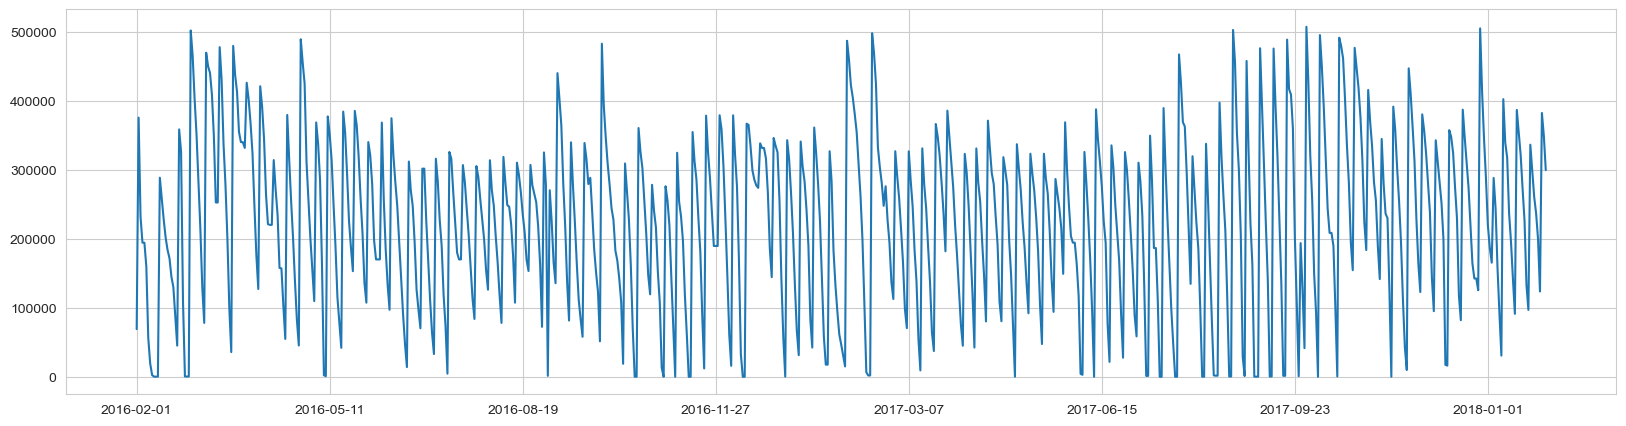

In [36]:
data[0].iloc[:, 4].plot(figsize=(20, 5))
test_stationarity(data[0].iloc[:, 4])
test_stationarity(data[0].iloc[:, 4].diff(1).dropna())

In [37]:
for i, m in enumerate(metrics_list):
	pd.DataFrame(m).to_csv(f'./ARIMA/cluster_{i}_metrics.csv', index=False)

In [38]:
pd.DataFrame(metrics_list[0]).mean(axis=0)

mse       1.340793e+10
s-rmse    6.344734e-01
s-mae     4.990425e-01
smape     5.246303e-01
dtype: float64

In [39]:
pd.DataFrame(metrics_list[1]).mean(axis=0)

mse       2.332427e+10
s-rmse    6.441321e-01
s-mae     5.132981e-01
smape     5.295039e-01
dtype: float64

In [40]:
pd.DataFrame(metrics_list[2]).mean(axis=0)

mse       3.925606e+10
s-rmse    6.333103e-01
s-mae     5.142560e-01
smape     5.591489e-01
dtype: float64

In [41]:
pd.DataFrame(metrics_list[3]).mean(axis=0)

mse       8.241135e+09
s-rmse    6.287329e-01
s-mae     4.765841e-01
smape     5.031728e-01
dtype: float64